<a href="https://colab.research.google.com/github/etemadism/MutCrisper/blob/master/MutCrisper_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MutCrisper: A Toolkit for Optimized gRNA Design in Base Editing Technology**    
This is a easy way to run MutCrisper in google colaboratory. The MutCrisper workflow, illustrated in Figure 1, is a comprehensive approach designed to enhance guide RNA (gRNA) design for precise base editing in genomic sequences. This workflow streamlines the process of selecting the most suitable gRNA sequences and predicting base editing outcomes.


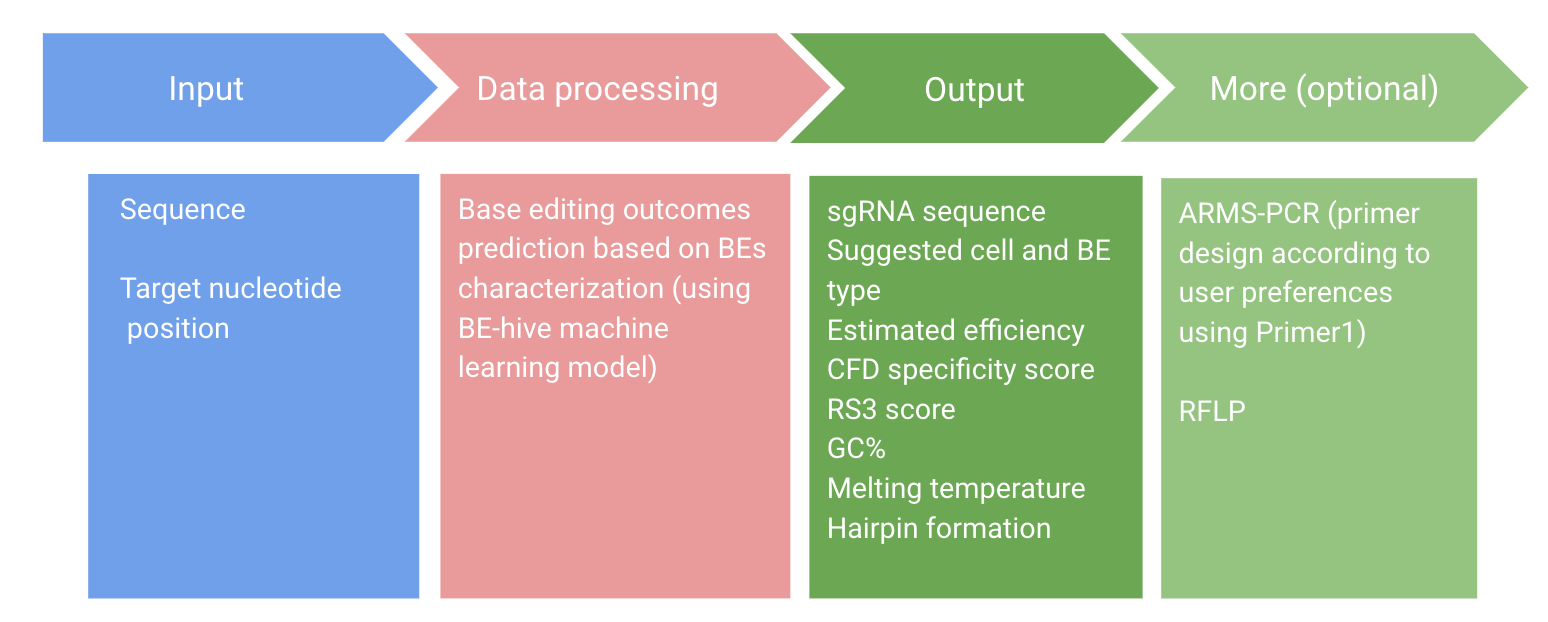

This figure illustrates the step-by-step MutCrisper workflow for optimizing guide RNA (gRNA) design and predicting base editing outcomes. Starting with input data and utilizing the BE-hive machine learning model, the process recommends cell and base editor types, estimates efficiency, evaluates specificity, and provides comprehensive information for improved base editing experiments. Subsequent steps involve ARMS-PCR primer design and RFLP analysis to verify successful base editing outcomes.


##1 Install required packages

In [3]:
%%capture
#@title Install required packages
#packages
!pip install Bio
!pip install primer3-py
!pip install regex
!pip install sglearn

#!pip install rs3
!git clone https://github.com/etemadism/MutCrisper.git
!git clone https://github.com/gpp-rnd/rs3.git
########libraries ######################
import re
from Bio.Seq import Seq
from tabulate import tabulate
import primer3
from Bio.Restriction import AllEnzymes
import subprocess
import os
from rs3.rs3.seq import predict_seq

In [4]:
#@title Functions
###### #######################
def validate_sequence(sequence):
    """
    Validates the input DNA sequence.
    """
    valid_chars = set("ACTG")
    if not set(sequence.upper()).issubset(valid_chars):
        raise ValueError("Invalid DNA sequence. Only A, C, T, G characters are allowed.")

def validate_nucleotide_position(position, sequence):
    """
    Validates the nucleotide position.
    """
    if position < 1 or position > len(sequence):
        raise ValueError("Invalid nucleotide position. Please enter a valid position within the sequence.")

def get_search_strand(sequence, position):
    """
    Determines the search strand based on the nucleotide at the position of interest.
    """
    nucleotide = sequence[position - 1]
    return "sense" if nucleotide in ["A", "C"] else "antisense"

def calculate_cg_percent(sequence):
    """
    Calculates the CG percent of a given sequence.
    """
    cg_count = sequence.count("C") + sequence.count("G")
    return (cg_count / len(sequence)) * 100

def find_pam_positions(sequence, search_strand):
    """
    Finds all PAM positions on the selected strand.
    """
    if search_strand == "sense":
        pam_motif = re.compile("(?=AGG|TGG|CGG|GGG)")
    else:
        pam_motif = re.compile("(?=AGG|TGG|CGG|GGG)") #?=CCA|CCT|CCC|CCG #
    return [match.start() for match in pam_motif.finditer(sequence)]



def find_sorted_efficacies(BE_profile, nucleotide_pos):
    efficacies = []

    for cell, enzyme, *efficacy_values in BE_profile:
        efficacy = efficacy_values[pos_grna]
        nucleotide = sequence[nucleotide_pos - 1]
        if nucleotide == 'A':
            if enzyme in ['ABE', 'ABE-CP']:
                if efficacy > 0:
                    efficacies.append((cell, enzyme, efficacy))
        else:
            if enzyme in ['BE4', 'BE4-CP', 'evoA-BE4', 'AID-BE4', 'eA3A-BE4', 'CDA-BE4']:
                if efficacy > 0:
                    efficacies.append((cell, enzyme, efficacy))

    sorted_efficacies = sorted(efficacies, reverse=True)
    return sorted_efficacies


def get_re_wild(wild, mut):
    enzymes = AllEnzymes
    for enzyme in enzymes:
        if enzyme.site in wild and enzyme.site not in mut:
            print(enzyme, enzyme.site)
    print(" ")

def get_re_mut(wild, mut):
    enzymes = AllEnzymes
    for enzyme in enzymes:
        if enzyme.site in mut and enzyme.site not in wild:
            print(enzyme, enzyme.site)
    print(" ")

def generate_mutant_sequence(sequence, nucleotide_pos):
    pos9 = nucleotide_pos - 9
    pos8 = nucleotide_pos + 8

    wild = sequence[pos9:pos8]
    #mut = wild[:8] + str(Seq(wild[8]).complement()) + wild[9:]
    # if search_strand== "sense":
    #     sequence=sequence
    # else:
    #     sequence= revcomp_sequence

    #wild = sequence[pos9:pos8]
    nuc_mut = Seq(wild[8])

    if nuc_mut == "A":
        mut = wild[:8] + "G" + wild[9:]
    elif nuc_mut == "C":
        mut = wild[:8] + "T" + wild[9:]
    else:
        mut = wild  # No mutation needed for other nucleotides

    print("This is the wild type sequence:   ", wild)
    print("This is the mutant type sequence: ", mut)

    print("These enzymes will potentially cut the wild sequence, but not mutant sequence.")
    get_re_wild(wild, mut)


    print("These enzymes will potentially cut the mutant sequence, but not wild sequence.")
    get_re_mut(wild, mut)

# Define the path to the CFD_Scoring directory
cfd_scoring_path = '/content/MutCrisper/CFD_Scoring'

# Function for CFD score calculation
def cfd_score_calculator(wt, off):
    # Store the current working directory
    current_dir = os.getcwd()

    try:
        # Change the current working directory temporarily for the subprocess
        os.chdir(cfd_scoring_path)

        command = f"python cfd_score_calculator.py --wt {wt} --off {off}"
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

        # Check if the subprocess was executed successfully
        if process.returncode != 0:
            raise RuntimeError(f"Error executing cfd_score_calculator.py: {stderr.decode()}")

        # Extract the numerical value from the output
        output = stdout.decode().strip()
        match = re.search(r"(\d+\.\d+)", output)
        if match:
            score = float(match.group(1))
        else:
            raise ValueError("Could not extract CFD score from the output.")

        return round(score, 3)
    finally:
        # Restore the original working directory
        os.chdir(current_dir)

In [5]:
#@title Base editor activity profile

####
######################################################################################################
##################Base editor activity profiles#######################################################
##################Reference: Mandana Arbab et al. Cell. 2020. doi:10.1016/j.cell.2020.05.037##########
######################################################################################################
BE_profile = [[
  'mESC', 'ABE', 0.0, 0.0, 0.0, 37.4, 85.1, 100.0, 77.7, 43.1, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'mESC', 'ABE-CP', 0.0, 0.0, 41.0, 83.9, 91.9, 100.0, 78.8, 63.1, 52.6, 50.5,
  0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'mESC', 'BE4', 0.0, 0.0, 31.8, 63.2, 90.3, 100.0, 87.0, 62.0, 31.4, 0.0, 0.0,
  0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'mESC', 'BE4-CP', 0.0, 42.5, 47.9, 69.3, 80.8, 92.1, 97.0, 100.0, 97.3, 91.7,
  76.8, 65.9, 59.6, 38.5, 34.7, 0, 0, 0, 0, 0], [
  'mESC', 'evoA-BE4', 0.0, 44.4, 72.1, 97.3, 100.0, 98.9, 86.7, 63.6, 36.5, 0.0,
  0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'mESC', 'AID-BE4', 46.1, 62.4, 82.4, 87.2, 90.2, 95.9, 100.0, 86.6, 76.9, 56.5,
  32.3, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'mESC', 'eA3A-BE4', 0.0, 0.0, 0.0, 41.6, 83.6, 100.0, 98.5, 75.7, 35.9, 0.0, 0.0,
  0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'mESC', 'CDA-BE4', 88.4, 98.9, 97.8, 99.4, 100.0, 93.5, 90.4, 68.8, 40.1, 0.0,
  0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'ABE', 0.0, 0.0, 0.0, 54.2, 74.2, 100.0, 86.1, 50.2, 0.0, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'ABE-CP', 0.0, 0.0, 39.4, 59.4, 75.7, 77.4, 100.0, 76.1, 58.3, 52.4, 44.6,
  0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'BE4', 0.0, 0.0, 36.1, 68.4, 100.0, 90.7, 72.2, 59.0, 37.3, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'BE4-CP', 0.0, 35.8, 50.4, 75.9, 81.3, 86.8, 83.7, 84.6, 100.0, 92.9, 92.0,
  59.5, 56.1, 56.2, 37.9, 0, 0, 0, 0, 0], [
  'HEK293T', 'evoA-BE4', 0.0, 39.7, 70.8, 97.7, 100.0, 94.8, 79.6, 67.1, 39.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'AID-BE4', 49.0, 62.0, 93.1, 87.9, 82.9, 100.0, 82.9, 97.0, 75.1, 65.6, 33.8,
  33.6, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'eA3A-BE4', 0.0, 0.0, 0.0, 35.8, 85.2, 100.0, 76.4, 73.7, 35.7, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'CDA-BE4', 80.8, 79.3, 84.6, 100.0, 83.3, 89.0, 80.0, 73.6, 57.3, 37.7, 0.0,
  0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'HEK293T', 'eA3A-BE5', 0.0, 0.0, 0.0, 42.1, 67.9, 95.9, 100.0, 65.6, 32.1, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'ABE', 0.0, 0.0, 0.0, 38.9, 100.0, 97.1, 83.5, 43.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
  0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'ABE-CP', 0.0, 0.0, 34.1, 71.5, 83.0, 100.0, 90.1, 82.2, 55.1, 49.1, 44.4, 0.0, 0.0,
  0.0, 0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'BE4', 0.0, 0.0, 41.1, 66.3, 100.0, 99.0, 93.2, 56.1, 40.3, 0.0, 0.0, 0.0, 0.0, 0.0,
  0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'BE4-CP', 0.0, 34.5, 57.0, 64.9, 90.5, 82.7, 82.9, 100.0, 94.1, 94.9, 79.9, 81.0,
  50.0, 32.0, 0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'evoA-BE4', 0.0, 32.1, 64.3, 92.4, 91.7, 100.0, 79.9, 61.2, 45.7, 0.0, 0.0, 0.0, 0.0,
  0.0, 0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'AID-BE4', 49.0, 62.0, 93.1, 87.9, 82.9, 100.0, 82.9, 97.0, 75.1, 65.6, 33.8, 33.6,
  0.0, 0.0, 0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'eA3A-BE4', 0.0, 0.0, 0.0, 0.0, 74.7, 100.0, 99.9, 65.7, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0,
  0.0, 0, 0, 0, 0, 0], [
  'U2OS', 'CDA-BE4', 80.8, 79.3, 84.6, 100.0, 83.3, 89.0, 80.0, 73.6, 57.3, 37.7, 0.0, 0.0, 0.0,
  0.0, 0.0, 0, 0, 0, 0, 0]]
########################################################################################################


##2 Inputs

In [22]:
#@title Please enter a DNA sequence and a position of the nucleotide of interest.


sequence = 'AGTGTGCAACCAAGCAACACAACTGCCAGTTCCTATGTGTTAACACCATTGGCGGCTTCACATGCAAATGTCC' #@param {type:"string"}
#sequence= input("Please enter a DNA sequence(with at least 20nt flanking in upstream and downstream of position of the nucleotide of interest): ")

nucleotide_pos = 36 # @param {type:"number"}

##3 Run MutCrisper

In [23]:
#@title Run MutCrisper
# Validate sequence
validate_sequence(sequence)
sequence = sequence.upper()
org_sequence=sequence

# Validate position
validate_nucleotide_position(nucleotide_pos, sequence)


org_nucleotide_pos=nucleotide_pos

###name of nucleotide of interest
org_nucleotide = sequence[org_nucleotide_pos - 1]

###mutation type for ARMS PCR
# Mutation type for ARMS PCR
if org_nucleotide == "A":
    mut_nucleotide = "G"
elif org_nucleotide == "C":
    mut_nucleotide = "T"
elif org_nucleotide == "T":
    mut_nucleotide = "C"
elif org_nucleotide == "G":
    mut_nucleotide = "A"
else:

    mut_nucleotide = None  # This is a wrong nt letter.



# Create a pattern to match the nucleotide of interest
nucleotide_pattern = re.compile(f"^(?P<before>.{{0,{nucleotide_pos-1}}})(?P<nucleotide>.)(?P<after>.*)$")

# Create a formatted string with the bold nucleotide position
formatted_sequence = nucleotide_pattern.sub("\g<before>\033[1m\g<nucleotide>\033[0m\g<after>", sequence)


# Print the formatted sequence
print(f"The position of interest is shown as bold: {formatted_sequence}")

# Determine the search strand based on the nucleotide at the position of interest
search_strand = get_search_strand(sequence, nucleotide_pos)
print(f"You need sgRNA for {search_strand} sequence.\n")



# Reverse complement the sequence if it's on the antisense strand
if search_strand == "antisense":
    revcomp_sequence = str(Seq(sequence).reverse_complement())

    nucleotide_pos= len(sequence)- (nucleotide_pos - 1)
    nucleotide_pattern = re.compile(f"(?P<before>.{{0,{nucleotide_pos-1}}})(?P<nucleotide>.)(?P<after>.*)")
    formatted_sequence = nucleotide_pattern.sub("\g<before>\033[1m\g<nucleotide>\033[0m\g<after>", revcomp_sequence)
    print(f"Here is reverse complement:                {formatted_sequence}")
if search_strand == "sense":
    sequence=sequence
else:
    sequence=revcomp_sequence

# Find all PAM positions on the selected strand
pam_positions = find_pam_positions(sequence if search_strand == "sense" else revcomp_sequence, search_strand)



# Find all gRNAs
sgRNA_list = []

for pos in pam_positions:
    if (search_strand == "sense" and 0 <= (pos - nucleotide_pos) < 20) or (search_strand == "antisense" and 0 <= (pos - nucleotide_pos) < 20):
        pPAM= pos + 3
        pPAM6= pos + 6
        gRNA_start = pos - 20
        gRNA_start4= pos - 24
        gPAM= sequence[gRNA_start:pPAM]
        qPAM30=sequence[gRNA_start4:pPAM6]

        if search_strand == "sense":

            gRNA = sequence[gRNA_start:pos]
            gRNA30 = sequence[gRNA_start4:pPAM6]

        else:

            gRNA = revcomp_sequence[gRNA_start:pos]
            gRNA30 = revcomp_sequence[gRNA_start4:pPAM6]

        # Check if gRNA is empty
        if not gRNA:
            print("Error: gRNA not found.")
            continue

        cg_percent = calculate_cg_percent(gRNA)

        nucleotide_pos = nucleotide_pos  # Specify the nucleotide position of interest
        end = pos + 1  #pos - 1
        start = end - 20
        pos_grna = 20 - (end - nucleotide_pos)
        wt = gPAM  # Assign gRNA to wt

        # Create a list of nucleotides in the gRNA with the specified replacements
        off_list = [nt if i != pos_grna else 'G' if nt == 'A' else 'T' if nt == 'C' else nt for i, nt in enumerate(gPAM)]

        # Join the modified nucleotides to form the off-gRNA sequence
        off = ''.join(off_list)
        # calculate cfd score
        cfd_score= cfd_score_calculator(wt, off)


        sorted_efficacies = find_sorted_efficacies(BE_profile, nucleotide_pos)
        tm= primer3.calc_tm(gRNA)
        Tm = round(tm, 2)
        hp=primer3.calc_hairpin(gRNA)
        Hairpin=hp.structure_found


        ###RS3 score
        #context_seqs = [gRNA30]
        # RS3_Hsu_score= predict_seq(context_seqs, sequence_tracr='Hsu2013')
        # RS3_Chen_score= predict_seq(context_seqs, sequence_tracr='Chen2013')


        sgRNA_list.append([gRNA +' NGG', sorted_efficacies, cfd_score, cg_percent, Tm, Hairpin ]) #RS3_Hsu_score,RS3_Chen_score,

print("                                 Table of sgRNA sequences and suggested conditions ")
print("----------------------------------------------------------------------------------------------------------------")

headers = ["sgRNA Sequence", "Cell     Enzyme  Efficacy(%)", "CFD specificity score", "GC(%)",  'Tm(°C)', "Hairpin?"]#"GC(%)","RS3 Score(Hsu)", "RS3 Score(Chen)",
for row in sgRNA_list:
    row[1] = tabulate(row[1], tablefmt="plain")  # Format sorted efficacies as a table
print(tabulate(sgRNA_list, headers=headers))

print("----------------------------------------------------------------------------------------------------------------")



The position of interest is shown as bold: AGTGTGCAACCAAGCAACACAACTGCCAGTTCCTATGTGTTAACACCATTGGCGGCTTCACATGCAAATGTCC
You need sgRNA for antisense sequence.

Here is reverse complement:                GGACATTTGCATGTGAAGCCGCCAATGGTGTTAACACATAGGAACTGGCAGTTGTGTTGCTTGGTTGCACACT
                                 Table of sgRNA sequences and suggested conditions 
----------------------------------------------------------------------------------------------------------------
sgRNA Sequence            Cell     Enzyme  Efficacy(%)      CFD specificity score    GC(%)    Tm(°C)  Hairpin?
------------------------  ------------------------------  -----------------------  -------  --------  ----------
CGCCAATGGTGTTAACACAT NGG                                                    0.375       45     54.85  True
TGGTGTTAACACATAGGAAC NGG                                                    0.652       40     50.68  True
-------------------------------------------------------------------------------------------

In [34]:
#@title 4 Restriction enzymes(if any) for RFLP

# Suppress the output of the %cd command
%cd -q /content/MutCrisper/primer1/primer1_source
!rm *.class

##Compile the Java source code
!javac doPrimer.java
#####Generate mutant sequence and find possible RFLP restriction enzyms
generate_mutant_sequence(sequence, nucleotide_pos)

This is the wild type sequence:    GATATATTAAAATGCCC
This is the mutant type sequence:  GATATATTGAAATGCCC
These enzymes will potentially cut the wild sequence, but not mutant sequence.
MseI TTAA
Tru9I TTAA
Tru1I TTAA
SaqAI TTAA
 
These enzymes will potentially cut the mutant sequence, but not wild sequence.
 


In [35]:
#@title 5 Please specify the parameters for ARMS PCR primer design(http://primer1.soton.ac.uk/primer1.html):
Optimum_primer_size = 28 #@param {type:"number"}
Maximum_primer_size= 30 #@param {type:"number"}
Minimum_primer_size= 26 #@param {type:"number"}
Optimum_inner_product_size = 200 #@param {type:"number"}
Maximum_inner_product_size= 300 #@param {type:"number"}
Minimum_inner_product_size= 50 #@param {type:"number"}
Maximum_relative_size = 1.5 #@param {type:"number"}
Minimum_relative_size= 1.1 #@param {type:"number"}
Optimum_primer_Tm= 65 #@param {type:"number"}
Maximum_primer_Tm= 80 #@param {type:"number"}
Minimum_primer_Tm= 50 #@param {type:"number"}
Maximum_primer_GC= 80 #@param {type:"number"}
Minimum_primer_GC= 10 #@param {type:"number"}
Maximum_complementarity= 8.0 #@param {type:"number"}
Maximum_3_complementarity= 3.0 #@param {type:"number"}
Salt_concentration_mM= 50 #@param {type:"number"}
Annealing_primer_concentration_mM= 50 #@param {type:"number"}
Number_of_outputs= 10 #@param {type:"number"}

!java -classpath /content/MutCrisper/primer1/primer1_source doPrimer '{org_sequence} {org_nucleotide_pos} {org_nucleotide} {mut_nucleotide} {Optimum_primer_size} {Maximum_primer_size} {Minimum_primer_size} {Optimum_inner_product_size} {Maximum_inner_product_size} {Minimum_inner_product_size} {Maximum_relative_size} {Minimum_relative_size} {Optimum_primer_Tm} {Maximum_primer_Tm} {Minimum_primer_Tm} {Maximum_primer_GC} {Minimum_primer_GC} {Maximum_complementarity} {Maximum_3_complementarity} {Salt_concentration_mM} {Annealing_primer_concentration_mM} {Number_of_outputs}'



print ('''

******************************************************Disclaimer:***********************************************
This code is for educational purposes only. Use it at your own risk. The author of this code makes no warranties
about the accuracy or suitability of this code for any purpose. By using this code, you agree to hold the author
harmless from any damages that may arise from its use.
''')


No appropriate outer reverse primers found
The product size range or size difference may limit the choice
Or GC content range too restrictive
Program abort


******************************************************Disclaimer:***********************************************
This code is for educational purposes only. Use it at your own risk. The author of this code makes no warranties
about the accuracy or suitability of this code for any purpose. By using this code, you agree to hold the author
harmless from any damages that may arise from its use.

